<a href="https://colab.research.google.com/github/Shibu4064/Thesis_Final/blob/main/HritThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>loading train, validation and test data<h1>

In [1]:
!pip install --quiet transformers

In [2]:
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AutoModelForMaskedLM, AutoTokenizer

In [3]:
###Hyperparameter for the new model
#defining some hyperparameters
max_number_input_tokens=512
batch_size_training = 8
first_dropout_rate = 0.0
hidden_output = 768
bert_model_name = "csebuetnlp/banglabert"
adam_opt_lr = 3e-5
scheduler_step = 1
scheduler_gamma = 0.98
epochs = 8
classes = 4
model_layer = ''
name_change=''
headlineContentSeparator = ' \\\\ '

#other options
isSaveModel = False

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
DirPath = ('/content/drive/MyDrive/THESIS/FakeNews/4-2/dataset/')
TestPath = DirPath+'test_cleaned.csv'
ValPath = DirPath+'val_cleaned.csv'
TrainPath = DirPath+'train_cleaned.csv'
ModelPath = DirPath+'/content/drive/MyDrive/THESIS/FakeNews/Models/'+'FNBaseline_buetbertrHritThesis.pth'

In [6]:
#df loading
df_train = pd.read_csv(TrainPath) # [['sentence','hate speech']]
df_val = pd.read_csv(ValPath)#[['sentence','hate speech']]
df_test = pd.read_csv(TestPath)#[['sentence','hate speech']]

#concatenating all the data
# df_train = pd.concat([df_train, df_val, df_test], ignore_index=True)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
display(df_train)
print(df_train.describe())
print(df_train['Label'].value_counts())
print(df_val['Label'].value_counts())
print(df_test['Label'].value_counts())

(42380, 3)
(9082, 3)
(9082, 3)


,Headline,Content,Label
0,কলকাতায় বোমা বিস্ফোরণে নিহত ১,ভারতের পশ্চিমবঙ্গের রাজধানী কলকাতায় একটি বাজার...,3
1,১৫ ঘণ্টা পর ময়মনসিংহের পথে ট্রেন চালু,ময়মনিসংহ স্টেশনের সুপারিনটেনডেন্ট জহিরুল হক জা...,2
2,ময়মনসিংহে আ.লীগের মামলায় আসামি ছাত্রলীগ,ময়মনসিংহ মহানগর আওয়ামী লীগের সভাপতি এহতেশামূল ...,3
3,পর্ণ দেখার শীর্ষে চট্টগ্রামের ছেলেরা,বন্দর নগরী চট্টগ্রামে পাশ্চাত্যের ছোঁয়া লেগেছ...,0
4,নড়াইলে কর্তব্যরত অবস্থায় পুলিশ সদস্যের মৃত্যু,নড়াইলের কালিয়ায় কর্তব্যরত অবস্থায় হৃদরোগে আক্র...,3
...,...,...,...
42375,নৌমন্ত্রীর আশ্বাসে কোটা বহালের আন্দোলন স্থগিত,নৌমন্ত্রীর আশ্বাসে সরকারি চাকরিতে কোটা বহালের ...,3
42376,কাঠগড়ায় দাঁড়াতে হয়েছিল শাস্ত্রীকে!,দুদিন আগেই এশিয়া কাপের শিরোপা নিয়ে সংযুক্ত আরব...,3
42377,ইয়াসের ক্ষতিপূরণ চেয়ে ভুরি ভুরি ‘ভুয়ো আবেদনপত্...,এ যেন সেই আমফানেরই পুনরাবৃত্তি। আমফানের পর ক্ষ...,2
42378,বগুড়ার সারিয়াকান্দিতে বন্যা পরিস্থিতি অবনতি,বগুড়ার সারিয়াকান্দিতে যমুনা নদীর পানি বৃদ্ধি অ...,3


              Label
count  42380.000000
mean       2.683223
std        0.729297
min        0.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        3.000000
3    34115
2     4629
1     2112
0     1524
Name: Label, dtype: int64
3    7289
2    1021
1     461
0     311
Name: Label, dtype: int64
3    7274
2    1017
1     444
0     347
Name: Label, dtype: int64


<h1>preparing training, validation and test data. Preparing model. Training model<h1>

In [7]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=max_number_input_tokens):
        self.data = data

        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True,
            "truncation_strategy":"longest_first"
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        # print(value["Headline"],value['Content']) #debugging dataloader
        return value['Headline']+headlineContentSeparator+str(value['Content']) , value['Label']

In [8]:
training_data = NewsDatasets(df_train)
train_dataloader = DataLoader(training_data, batch_size=batch_size_training, shuffle=True)

val_data = NewsDatasets(df_val)
val_dataloader = DataLoader(val_data, batch_size=batch_size_training, shuffle=False)

test_data = NewsDatasets(df_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size_training, shuffle=False)

In [9]:
class BERTBengali(nn.Module):
    def __init__(self, bert):
        super(BERTBengali, self).__init__()
        #self.bert = BertForMaskedLM.from_pretrained("sagorsarker/bangla-bert-base")
        self.bert = bert
        self.bert_drop = nn.Dropout(first_dropout_rate)
        self.out = nn.Linear(hidden_output, classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        bo = self.bert_drop(output[1])

        output = self.out(bo)
        return output

In [10]:
bert = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# bert = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)
model = BERTBengali(bert)
# model2Forlastlayers = CustomBERTBengali(bert)

model.to(device)
# model2Forlastlayers.to(device)
# model2Forlastlayers.load_state_dict(torch.load(DirPath+'Models by Sami/'+bert_model_name+"_modeltest.pth"))

# model.l0 = model2Forlastlayers.l0
# model.l2 = model2Forlastlayers.l1
# model.bert = model2Forlastlayers.bert

# model.load_state_dict(torch.load(DirPath+bert_model_name+"_lasttwopoolerf_contest_val_from_HScollected_lastfrozen_acc1_sub.pth"))

# for params in model.bert.parameters():
#   params.requires_grad = False
# for params in model.bert.embeddings.parameters():
#   params.requires_grad = True
# for params in model.bert.encoder.parameters():
#   params.requires_grad = False
# # for params in model.l2.parameters():
# #   params.requires_grad = True
# # for params in model.l1.parameters():
# #   params.requires_grad = True
# for params in model.l0.parameters():
#   params.requires_grad = True

for name, param in model.named_parameters():
  if param.requires_grad:
      print(f"name: {name} is trainable")
  else:
      print(f"name: {name} is non-trainable")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['encoder.layer.11.attention.self.key.weight', 'encoder.layer.3.attention.output.dense.bias', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.6.output.LayerNorm.weight', 'encoder.layer.8.output.LayerNorm.weight', 'encoder.layer.10.attention.self.query.bias', 'encoder.layer.7.attention.self.value.bias', 'encoder.layer.7.attention.output.dense.weight', 'encoder.layer.9.intermediate.dense.weight', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.3.intermediate.dense.weight', 'encoder.layer.2.intermediate.dense.bias', 'encoder.layer.8.attention.self.value.bias', 'encoder.layer.3.attention.self.value.weight', 'encoder.layer.10.attention.output.dense.bias', 'embeddings.LayerNorm.bias', 'encoder.layer.11.attention.output.LayerNorm.weight', 'encoder.layer.1.attention.output.dense.weight', 'encoder.layer.7.output.LayerNorm.bias', 'encoder.layer.9.at

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

name: bert.embeddings.word_embeddings.weight is trainable
name: bert.embeddings.position_embeddings.weight is trainable
name: bert.embeddings.token_type_embeddings.weight is trainable
name: bert.embeddings.LayerNorm.weight is trainable
name: bert.embeddings.LayerNorm.bias is trainable
name: bert.encoder.layer.0.attention.self.query.weight is trainable
name: bert.encoder.layer.0.attention.self.query.bias is trainable
name: bert.encoder.layer.0.attention.self.key.weight is trainable
name: bert.encoder.layer.0.attention.self.key.bias is trainable
name: bert.encoder.layer.0.attention.self.value.weight is trainable
name: bert.encoder.layer.0.attention.self.value.bias is trainable
name: bert.encoder.layer.0.attention.output.dense.weight is trainable
name: bert.encoder.layer.0.attention.output.dense.bias is trainable
name: bert.encoder.layer.0.attention.output.LayerNorm.weight is trainable
name: bert.encoder.layer.0.attention.output.LayerNorm.bias is trainable
name: bert.encoder.layer.0.inter

In [11]:
#testing if the input of model works before starting training
s = "আমি বাংলায় গান গাই। [SEP]"

# debugging dataloader
# i = 0
# for batch in train_dataloader:
#   text, labels = batch
#   for j in range(len(text)):
#     print(i+1)
#     i+=1

# s=headlineContentSeparator
# print(s)
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[   2,  857,    1, 1755, 3893,  205,    3,    3]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[ 0.0041, -0.0163,  0.1445,  0.0101]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [12]:
print(df_train.iloc[94]['Headline'],df_train.iloc[94]['Content'])

বিলে স্পিকারের সই, আজ যাচ্ছে রাষ্ট্রপতির কাছে   *মঙ্গলবার সই করেছেন জাতীয় সংসদের স্পিকার *আজ নথি রাষ্ট্রপতির দপ্তরে পাঠানো হতে পারে *বিলটি রাষ্ট্রপতির অনুমোদন পেতে যাচ্ছে *সংশোধন নির্ভর করছে নীতিনির্ধারকদের ওপর *সিদ্ধান্ত গতকাল পর্যন্ত মন্ত্রী–সচিবদের কাছে যায়নি *আজ মন্ত্রিসভার বৈঠকে আলোচনা হতে পারে সম্পাদকদের সঙ্গে আলোচনা শুরু হলেও ডিজিটাল নিরাপত্তা আইনটি কার্যকর হতে যাচ্ছে। সংসদে পাস হওয়া বিলটিতে গতকাল মঙ্গলবার সই করেছেন জাতীয় সংসদের স্পিকার শিরীন শারমিন চৌধুরী। আজ এ-সংক্রান্ত নথিটি সংসদ সচিবালয় থেকে রাষ্ট্রপতির দপ্তরে পাঠানো হতে পারে। সরকারের উচ্চপর্যায়ের একাধিক সূত্র জানায়, জাতীয় সংসদে পাস হওয়া অন্যান্য বিলের মতো ডিজিটাল নিরাপত্তা বিলটিও রাষ্ট্রপতির অনুমোদন পেতে যাচ্ছে। এরপর আইনটি সংশোধন হবে কি না, তা নির্ভর করছে সরকারের নীতিনির্ধারক পর্যায়ের সিদ্ধান্তের ওপর। সেই সিদ্ধান্ত গতকাল পর্যন্ত সংশ্লিষ্ট মন্ত্রী বা সচিবদের কাছে যায়নি। একাধিক মন্ত্রী প্রথম আলোকে জানান, আজ মন্ত্রিসভার বৈঠকে অনির্ধারিত আলোচনায় বিষয়টি নিয়ে প্রধানমন্ত্রী বা সংশ্লিষ্ট কোনো মন্ত্রী আলোচনা করতে পারেন। প্রধানমন্ত্র

In [13]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=adam_opt_lr)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

In [14]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        #labels = labels.to(device)
        labels = labels.to(device, dtype=torch.long)  # Convert labels to torch.long

        # move things to model
        logs = model( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        loss = criterion(logs, labels)
        #print("successfully calculated criterion in train!")
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [15]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0
    label_0_TP = 0
    label_0_TN = 0
    label_0_FP = 0
    label_0_FN = 0

    label_1_TP = 0
    label_1_TN = 0
    label_1_FP = 0
    label_1_FN = 0

    label_2_TP = 0
    label_2_TN = 0
    label_2_FP = 0
    label_2_FN = 0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device, dtype=torch.long)

        # move things to model
        output = model(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(f'predicted: {predicted} labels: {labels}')
        label_0_TP += ((predicted == 0) & (labels == 0)).sum().item()
        label_0_TN += ((predicted != 0) & (labels != 0)).sum().item()
        label_0_FP += ((predicted == 0) & (labels != 0)).sum().item()
        label_0_FN += ((predicted != 0) & (labels == 0)).sum().item()

        label_1_TP += ((predicted == 1) & (labels == 1)).sum().item()
        label_1_TN += ((predicted != 1) & (labels != 1)).sum().item()
        label_1_FP += ((predicted == 1) & (labels != 1)).sum().item()
        label_1_FN += ((predicted != 1) & (labels == 1)).sum().item()

        label_2_TP += ((predicted == 2) & (labels == 2)).sum().item()
        label_2_TN += ((predicted != 2) & (labels != 2)).sum().item()
        label_2_FP += ((predicted == 2) & (labels != 2)).sum().item()
        label_2_FN += ((predicted != 2) & (labels == 2)).sum().item()

    return total, correct, valid_loss, label_0_TP, label_0_TN, label_0_FP, label_0_FN, label_1_TP, label_1_TN, label_1_FP, label_1_FN, label_2_TP, label_2_TN, label_2_FP, label_2_FN


In [16]:

tokenizer_config = {
    "max_length": max_number_input_tokens,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True,
     "truncation_strategy":"longest_first"
}

In [18]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf
best_acc=0
sml = 1e-10
best_f1=0.0

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    label_0_TP = 0
    label_0_TN = 0
    label_0_FP = 0
    label_0_FN = 0

    label_1_TP = 0
    label_1_TN = 0
    label_1_FP = 0
    label_1_FN = 0

    label_2_TP = 0
    label_2_TN = 0
    label_2_FP = 0
    label_2_FN = 0


    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, val_dataloader, criterion, tokenizer_config)
    torch.save(model.state_dict(), ModelPath)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    label_0_TP += out[3]
    label_0_TN += out[4]
    label_0_FP += out[5]
    label_0_FN += out[6]

    label_1_TP += out[7]
    label_1_TN += out[8]
    label_1_FP += out[9]
    label_1_FN += out[10]

    # label_2_TP += out[11]
    # label_2_TN += out[12]
    # label_2_FP += out[13]
    # label_2_FN += out[14]

    # Calculate precision, recall, and F1-score for each class
    label_0_precision = label_0_TP / (label_0_TP + label_0_FP+sml)
    label_0_recall = label_0_TP / (label_0_TP + label_0_FN+sml)
    label_0_f1_score = 2 * (label_0_precision * label_0_recall) / (label_0_precision + label_0_recall+sml)

    label_1_precision = label_1_TP / (label_1_TP + label_1_FP+sml)
    label_1_recall = label_1_TP / (label_1_TP + label_1_FN+sml)
    label_1_f1_score = 2 * (label_1_precision * label_1_recall) / (label_1_precision + label_1_recall+sml)

    label_2_precision = label_2_TP / (label_2_TP + label_2_FP+sml)
    label_2_recall = label_2_TP / (label_2_TP + label_2_FN+sml)
    label_2_f1_score = 2 * (label_2_precision * label_2_recall) / (label_2_precision + label_2_recall+sml)

    # Calculate combined F1-score
    combined_f1_score = (label_0_f1_score + label_1_f1_score) / 2

    # Calculate micro TP, TN, FP, FN values
    micro_TP = label_0_TP + label_1_TP
    micro_TN = label_0_TN + label_1_TN
    micro_FP = label_0_FP + label_1_FP
    micro_FN = label_0_FN + label_1_FN

    # Calculate micro precision, recall, and F1 score
    micro_precision = micro_TP / (micro_TP + micro_FP)
    micro_recall = micro_TP / (micro_TP + micro_FN)
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(val_dataloader.dataset)

    val_acc=correct / total * 100

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)

    if combined_f1_score > best_f1:
        best_f1 = combined_f1_score
        torch.save(model.state_dict(), ModelPath)
        print(f'saved on epoch: {epoch+1}')

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tVal Accuracy: {:.4f}".format(correct / total * 100))
    print("\tLabel 0 Precision: {:.4f}\tLabel 0 Recall: {:.4f}\tLabel 0 F1-score: {:.4f}\n"
      "\tLabel 1 Precision: {:.4f}\tLabel 1 Recall: {:.4f}\tLabel 1 F1-score: {:.4f}\n"
      "\tLabel 2 Precision: {:.4f}\tLabel 2 Recall: {:.4f}\tLabel 2 F1-score: {:.4f}\n"
      "\tCombined F1-score: {:.4f}".format(label_0_precision, label_0_recall, label_0_f1_score,
                                            label_1_precision, label_1_recall, label_1_f1_score,
                                            label_2_precision, label_2_recall, label_2_f1_score,
                                            combined_f1_score))
    print(f'micro precision: {micro_precision}, Micro recall: {micro_recall}, micro f1: {micro_f1}')

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/8


  0%|          | 0/5298 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
torch.save(model.state_dict(), "/content/drive/MyDrive/THESIS/FakeNews/Models/THESIS1.pth")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# torch.save(model.state_dict(), DirPath+bert_model_name+"_lasttwopoolerf_contest_val_from_finalhs_midnonfrozen_acc1_sub_finaluntested.pth")

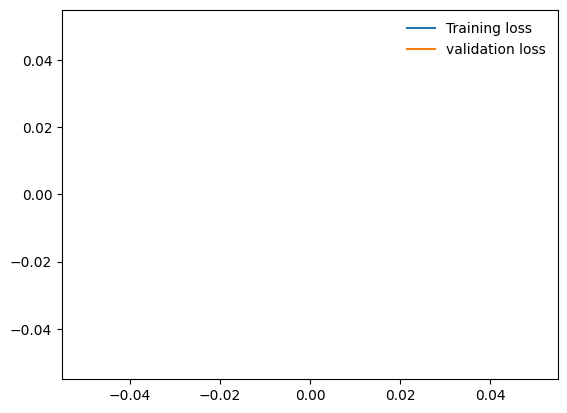

In [21]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing on test dataset

In [22]:
model.load_state_dict(torch.load("/content/drive/MyDrive/THESIS/FakeNews/Models/THESIS1.pth"))

<All keys matched successfully>

In [23]:
all_preds = []
all_labels = []


df_test = pd.read_csv(TestPath)
test_data = NewsDatasets(df_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size_training, shuffle=False)

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

# df_test['real_HS'] = all_labels
# df_test['predicted_HS'] = all_preds
# df_test.to_csv(DirPath+'nc/'+'test_HS_pred.csv')

In [24]:
print(len(all_preds))

9082


In [25]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       347
           1     0.0000    0.0000    0.0000       444
           2     0.0000    0.0000    0.0000      1017
           3     0.8009    1.0000    0.8895      7274

    accuracy                         0.8009      9082
   macro avg     0.2002    0.2500    0.2224      9082
weighted avg     0.6415    0.8009    0.7124      9082



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
